# Chicago Transit Authority - Forecasting train and bus passenger numbers

![alt text](images/cta_train.jpg "cta_train")


# Summary

In [146]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf

%matplotlib inline
pd.set_option("future.no_silent_downcasting", True)


In [147]:
df = pd.read_csv('data/CTA_-_Ridership_-_Daily_Boarding_Totals_20240908.csv',parse_dates=['service_date'])
df.head()

,service_date,day_type,bus,rail_boardings,total_rides
0,2001-01-01,U,297192,126455,423647
1,2001-01-02,W,780827,501952,1282779
2,2001-01-03,W,824923,536432,1361355
3,2001-01-04,W,870021,550011,1420032
4,2001-01-05,W,890426,557917,1448343


In [148]:
#We start by changing column names to shorter ones
df.columns = ['date','day_type','bus','rail','total']

In [149]:
df.head()

,date,day_type,bus,rail,total
0,2001-01-01,U,297192,126455,423647
1,2001-01-02,W,780827,501952,1282779
2,2001-01-03,W,824923,536432,1361355
3,2001-01-04,W,870021,550011,1420032
4,2001-01-05,W,890426,557917,1448343


Day type stands for:

- W if it is a Week Day;
- A if it is a Saturday;
- U if it is a Sunday or Holiday.

In [150]:
df = df.sort_values('date',ascending=True).set_index('date') #Make sure data is organized by date
df.drop('total',axis=1, inplace=True) #We are not interested in predicting total number of passengers

In [151]:
df.isna().sum()

day_type    0
bus         0
rail        0
dtype: int64

In [152]:
# No null values to drop

In [153]:
df[df.duplicated()]

,day_type,bus,rail
date,,,
2011-10-01,A,701783,480889
2011-10-02,U,486409,344520
2011-10-03,W,1091676,751034
2011-10-04,W,1090878,767029
2011-10-05,W,1083300,774142
...,...,...,...
2014-07-27,U,423806,403719
2014-07-28,W,810122,730188
2014-07-29,W,810857,746646


In [154]:
df.drop_duplicates(inplace=True)

In [155]:
df.head()

,day_type,bus,rail
date,,,
2001-01-01,U,297192,126455
2001-01-02,W,780827,501952
2001-01-03,W,824923,536432
2001-01-04,W,870021,550011
2001-01-05,W,890426,557917


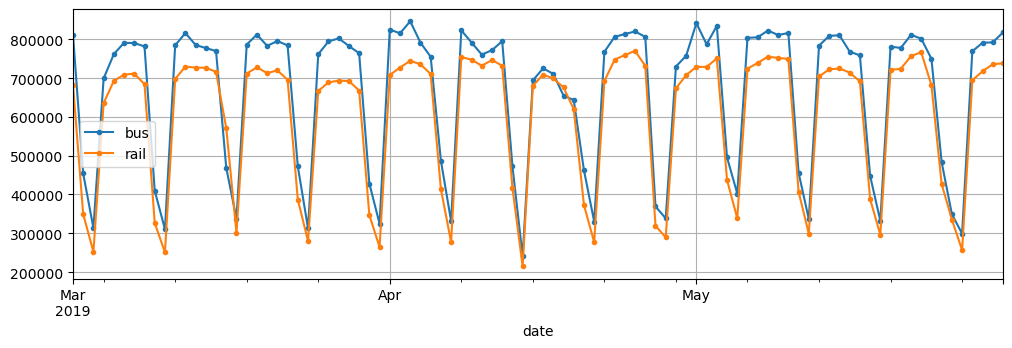

In [156]:
#Daily ridership for bus and rail
df['03-2019':'05-2019'].plot(grid=True,marker='.', figsize=(12,3.5))
plt.show()

We can observe weekly seasonality in this plot.

In order to actually observe that in more detail, we overleay two time series (for bus and rail) as well as the same time series lagged by one week.

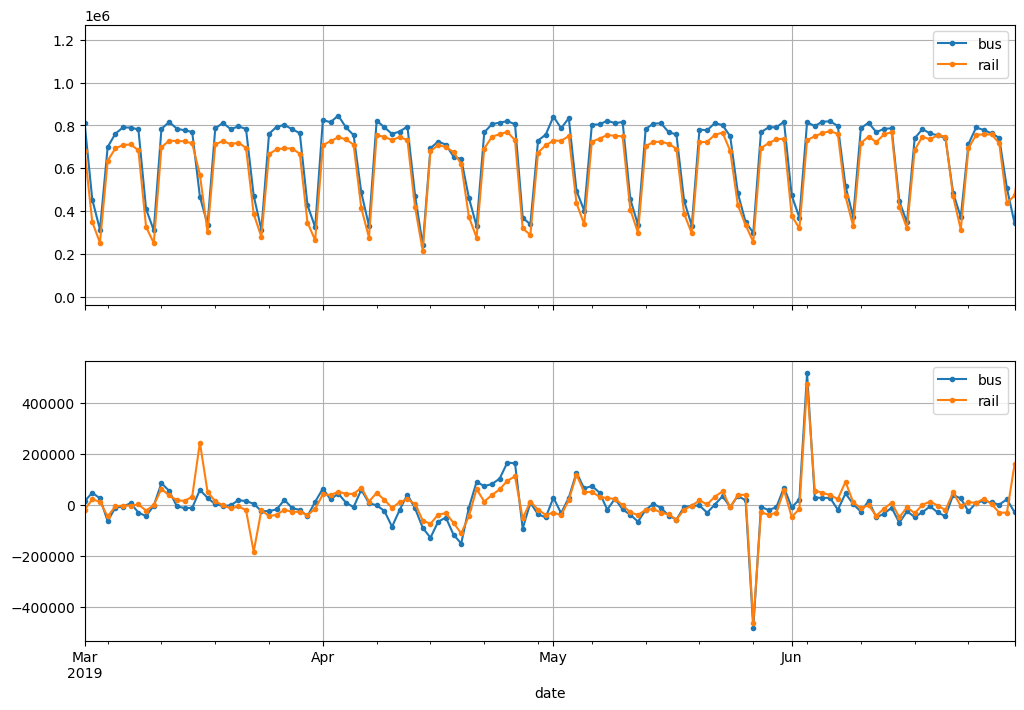

In [157]:
diff_7 = df[['bus','rail']].diff(7)['2019-03':'2019-06']

fig,axs = plt.subplots(2,1,sharex=True,figsize=(12,8))
df.plot(ax=axs[0],grid=True,marker='.') #Original plot
diff_7.plot(ax=axs[1],grid=True,marker='.'); #7 day difference time series

The differenced series shows that bus and rail had a decline in use during late May. This can be caused by a long weekend that a lot of people decided to travel for example. We can explore that by trying to find out what days this was observed and what kind of day they were.

In [158]:
diff_7['2019-05-20':'2019-05-31']

,bus,rail
date,,
2019-05-20,-2596.0,17071.0
2019-05-21,-31216.0,1359.0
2019-05-22,1086.0,31878.0
2019-05-23,33447.0,52435.0
2019-05-24,-8572.0,-9947.0
2019-05-25,34994.0,38559.0
2019-05-26,17362.0,39506.0
2019-05-27,-482074.0,-464640.0
2019-05-28,-8578.0,-29490.0


The decline was observed in May 27th 2019, so let us see what kind of days that week presented.

In [159]:
df['2019-05-24':'2019-05-29']['day_type']

date
2019-05-24    W
2019-05-25    A
2019-05-26    U
2019-05-27    U
2019-05-28    W
2019-05-29    W
Name: day_type, dtype: object

So it seems that the the 27th was a Monday but also a Holiday and the weekend if the 25th-27th was a long weekend. While we expected a lot of people to take public transportation system on Monday, because it was a holiday, not a lot of people took the bus or rail even to come back home from the airport.

Although not a good prediction most of the time (as showed up), we can use the seasonality of this dataset as a naive forecast and baseline model to compare our models. For that we will use the Root Mean Squared Error. This metric is important because it adds a larger toll to larger errors which correspond to predicting more riders than we get (additional costs for no reason) or predicting way less riders than we get (which can lead to people waiting for their transportation for longer and poor feedback from population) but it still measures error in people and not people squared. We will also be using the month of August of 2019 to compare predictions.

In [160]:
#Naive method RMSE is
naive_RMSE = (((df[['bus','rail']].diff(7)['2019-08':'2019-08-31'].abs())**2).mean())**0.5
naive_RMSE

bus     35653.526950
rail    52179.905866
dtype: float64

Therefore:

|Model|Bus RMSE| Rail RMSE|
|----|----|---|
|Naive Forecast| 35653|52179|

It does not look like we observe a monthly seasonality but let us explore if there is other types of seasonalities, such as yearly seasonality.

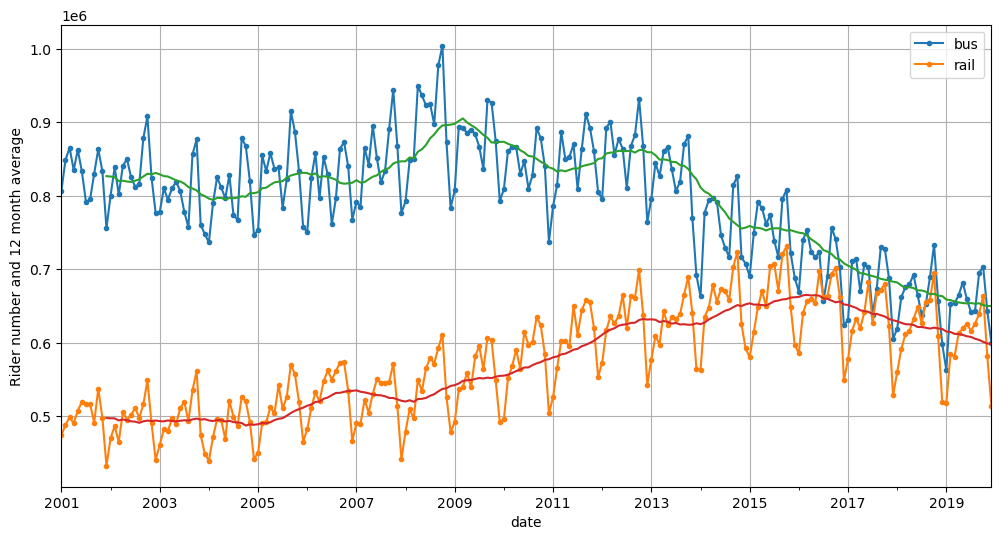

In [161]:
period = slice('2001','2019')
df_monthly = df.drop('day_type',axis=1).resample('ME').mean() # Get the mean for each month
rolling_average_12_months = df_monthly[period].rolling(window=12).mean() #12 month rolling average

fid,ax = plt.subplots(figsize=(12,6))
df_monthly[period].plot(ax=ax,marker='.')
rolling_average_12_months.plot(ax=ax,grid=True,legend=False)
plt.ylabel('Rider number and 12 month average');

Definitely we have some year seasonality. We can see people take the public transportation system way less in December due to the holidays and during summer.

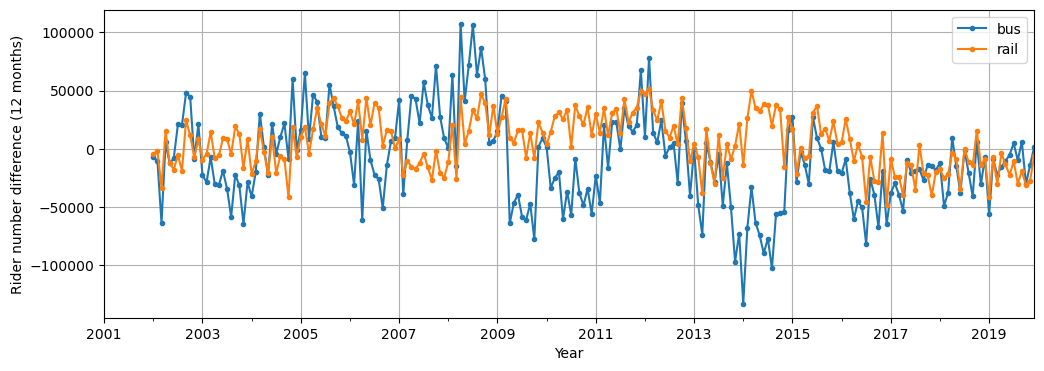

In [162]:
df_monthly.diff(12)[period].plot(grid=True, marker='.', figsize=(12,4))
plt.ylabel('Rider number difference (12 months)')
plt.xlabel('Year');

# 1st Model - Seasonal AutoRegressive Integrated Moving Average (SARIMA)

In [163]:
from statsmodels.tsa.arima.model import ARIMA

origin, today = '2019-01-01', '2019-05-31'
rail_series = df.loc[origin:today]['rail'].asfreq("D") 
#Setting up frequency as daily. Doesn't change the data (in this case) but ARIMA needs this
model = ARIMA(rail_series,
              order=(1,0,0),
              seasonal_order=(0,1,1,7))

In [164]:
model = model.fit()

In [165]:
y_pred = model.forecast()

In [166]:
# We check the prediction for tomorrow (day after variable today)
y_pred

2019-06-01    427758.626286
Freq: D, dtype: float64

Now if we want to predict more days, we can run a loop such as

In [167]:
origin, start_date, end_date = '2019-01-01', '2019-08-01', '2019-08-31'
time_period = pd.date_range(start_date, end_date)
rail_series = df.loc[origin:end_date]['rail'].asfreq('D')
y_preds=[]
for today in time_period.shift(-1):
    model = ARIMA(rail_series[origin:today],
                  order=(1,0,0),
                  seasonal_order=(0,1,1,7))
    model = model.fit()
    y_pred = model.forecast()[0]
    y_preds.append(y_pred)
y_preds = pd.Series(y_preds,index=time_period)
SARIMA_rail_RMSE = ((y_preds-rail_series[time_period]).abs()**2).mean()**0.5
SARIMA_rail_RMSE

/tmp/ipykernel_1116855/350131292.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_pred = model.forecast()[0]
/tmp/ipykernel_1116855/350131292.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_pred = model.forecast()[0]
/tmp/ipykernel_1116855/350131292.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_pred = model.forecast()[0]
/tmp/ipykernel_1116855/350131292.py:10: FutureWarning: Series.__getitem__ treating keys as 

24143.36110458119

In [168]:
origin, start_date, end_date = '2019-01-01', '2019-08-01', '2019-08-31'
time_period = pd.date_range(start_date, end_date)
bus_series = df.loc[origin:end_date]['bus'].asfreq('D')
y_preds=[]
for today in time_period.shift(-1):
    model = ARIMA(bus_series[origin:today],
                  order=(1,0,0),
                  seasonal_order=(0,1,1,7))
    model = model.fit()
    y_pred = model.forecast()[0]
    y_preds.append(y_pred)
y_preds = pd.Series(y_preds,index=time_period)
SARIMA_rail_RMSE = ((y_preds-bus_series[time_period]).abs()**2).mean()**0.5
SARIMA_rail_RMSE

/tmp/ipykernel_1116855/396425450.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_pred = model.forecast()[0]
/tmp/ipykernel_1116855/396425450.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_pred = model.forecast()[0]
/tmp/ipykernel_1116855/396425450.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_pred = model.forecast()[0]
/tmp/ipykernel_1116855/396425450.py:10: FutureWarning: Series.__getitem__ treating keys as 

29549.225436240617

Not bad! SARIMA did a bit better than our naive forecasting but we are still getting the rider forecast very wrong:

|Model|Bus RMSE| Rail RMSE|
|----|----|---|
|Naive Forecast| 35653|52179|
|SARIMA| 24143|29549|

# 2nd Model - Linear Model

We need to split our data into a training period, a validation period and a test period.

In [169]:
rail_train = df['rail']['2016-01':'2018-12']/10.**6
rail_valid = df['rail']['2019-01':'2019-06-04']/10.**6
rail_test = df['rail']['2019-06-06':'2019-08-31']/10.**6

bus_train = df['bus']['2016-01':'2018-12']/10.**6
bus_valid = df['bus']['2019-01':'2019-06-04']/10.**6
bus_test = df['bus']['2019-06-06':'2019-08-31']/10.**6

In [170]:
seq_length = 56
rail_train_ds = tf.keras.preprocessing.timeseries_dataset_from_array(
    data=rail_train.to_numpy(),
    targets=rail_train[seq_length:],
    sequence_length=seq_length,
    batch_size=32,
    shuffle=True,
    seed=19
)

rail_valid_ds = tf.keras.preprocessing.timeseries_dataset_from_array(
    rail_valid.to_numpy(),
    targets=rail_valid[seq_length:],
    sequence_length=seq_length,
    batch_size=32
)

rail_test_ds = tf.keras.preprocessing.timeseries_dataset_from_array(
    rail_test.to_numpy(),
    targets=rail_test[seq_length:],
    sequence_length=seq_length,
    batch_size=32
)

In [171]:
tf.random.set_seed(19)
model = tf.keras.Sequential([
    tf.keras.layers.Dense(1,input_shape=[seq_length])    
])

early_stopping_cb = tf.keras.callbacks.EarlyStopping(mode='min',monitor='val_RootMeanSquaredError', patience=50, restore_best_weights=True)
opt = tf.keras.optimizers.SGD(learning_rate=0.02,momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),optimizer=opt,metrics=['RootMeanSquaredError'])
history = model.fit(rail_train_ds, validation_data=rail_valid_ds,epochs=500,callbacks=[early_stopping_cb])

Epoch 1/500


/home/cayke/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - RootMeanSquaredError: 1.0291 - loss: 0.4869 - val_RootMeanSquaredError: 0.1761 - val_loss: 0.0155
Epoch 2/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - RootMeanSquaredError: 0.2177 - loss: 0.0240 - val_RootMeanSquaredError: 0.1094 - val_loss: 0.0060
Epoch 3/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - RootMeanSquaredError: 0.1354 - loss: 0.0092 - val_RootMeanSquaredError: 0.0941 - val_loss: 0.0044
Epoch 4/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - RootMeanSquaredError: 0.1257 - loss: 0.0079 - val_RootMeanSquaredError: 0.0914 - val_loss: 0.0042
Epoch 5/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - RootMeanSquaredError: 0.1189 - loss: 0.0071 - val_RootMeanSquaredError: 0.0931 - val_loss: 0.0043
Epoch 6/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - RootMeanSquaredError: 0.1072 - loss: 0.0058 - val_RootMeanSquaredError: 0.0949 - val_loss: 0.0045
Epoch 7/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - RootMeanSquaredError: 0.1125 - loss: 0.0063 - val_Roo

In [172]:
y_pred_rail_linearmodel = model.predict(rail_test_ds)
y_test_rail = rail_test[seq_length:].to_numpy()
size = len(y_test_rail)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


In [173]:
RMSE_rail_linearmodel = ((sum((y_pred_rail_linearmodel.reshape(-1) - y_test_rail)**2))/size)**0.5
RMSE_rail_linearmodel

0.0357881298493612

RMSE for the rail on the test set was 35788

In [174]:
bus_train_ds = tf.keras.preprocessing.timeseries_dataset_from_array(
    data=bus_train.to_numpy()[:-seq_length],
    targets=bus_train[seq_length:],
    sequence_length=seq_length,
    batch_size=32,
    shuffle=True,
    seed=19
)

bus_valid_ds = tf.keras.preprocessing.timeseries_dataset_from_array(
    bus_valid.to_numpy(),
    targets=bus_valid[seq_length:],
    sequence_length=seq_length,
    batch_size=32
)

bus_test_ds = tf.keras.preprocessing.timeseries_dataset_from_array(
    bus_test.to_numpy(),
    targets=bus_test[seq_length:],
    sequence_length=seq_length,
    batch_size=32
)

In [175]:
tf.random.set_seed(19)
model = tf.keras.Sequential([
    tf.keras.layers.Dense(1,input_shape=[seq_length])    
])

early_stopping_cb = tf.keras.callbacks.EarlyStopping(mode='min',monitor='val_RootMeanSquaredError', patience=50, restore_best_weights=True)
opt = tf.keras.optimizers.SGD(learning_rate=0.02,momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),optimizer=opt,metrics=['RootMeanSquaredError'])
history = model.fit(bus_train_ds, validation_data=bus_valid_ds,epochs=500,callbacks=[early_stopping_cb])

Epoch 1/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - RootMeanSquaredError: 1.3298 - loss: 0.7316 - val_RootMeanSquaredError: 0.4257 - val_loss: 0.0906
Epoch 2/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - RootMeanSquaredError: 0.2691 - loss: 0.0374 - val_RootMeanSquaredError: 0.1554 - val_loss: 0.0121
Epoch 3/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - RootMeanSquaredError: 0.1414 - loss: 0.0100 - val_RootMeanSquaredError: 0.1357 - val_loss: 0.0092
Epoch 4/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - RootMeanSquaredError: 0.1334 - loss: 0.0089 - val_RootMeanSquaredError: 0.1403 - val_loss: 0.0098
Epoch 5/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - RootMeanSquaredError: 0.1275 - loss: 0.0081 - val_RootMeanSquaredError: 0.1191 - val_loss: 0.0071
Epoch 6/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - RootMeanSquaredError: 0.1197 - loss: 0.0072 - val_RootMeanSquaredError: 0.1187 - val_loss: 0.0070
Epoch 7/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - RootMeanSquaredError: 0.1166 - loss: 0.00

In [176]:
y_pred_bus_linearmodel = model.predict(bus_test_ds)
y_test_bus = bus_test[seq_length:].to_numpy()
size = len(y_test_bus)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


In [177]:
RMSE_bus_linearmodel = ((sum((y_pred_bus_linearmodel.reshape(-1) - y_test_bus)**2))/size)**0.5
RMSE_bus_linearmodel

0.03162619131072939

Validation root mean squared error for the bus was 32025

Our linear model did worse than naive forecasting and SARIMA

|Model|Bus RMSE| Rail RMSE|
|----|----|---|
|Naive Forecast| 35653|52179|
|SARIMA| 24143|29549|
|Linear Model| 31626|35788|

# 3rd Model - Simple RNN

In [178]:
model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(1,input_shape=[None,1])
])

early_stopping_cb = tf.keras.callbacks.EarlyStopping(mode='min',monitor='val_RootMeanSquaredError', patience=50, restore_best_weights=True)
opt = tf.keras.optimizers.SGD(learning_rate=0.02, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(), optimizer=opt, metrics=['RootMeanSquaredError'])
history = model.fit(rail_train_ds, validation_data=rail_valid_ds, epochs=500, callbacks=[early_stopping_cb])

Epoch 1/500


/home/cayke/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - RootMeanSquaredError: 0.4384 - loss: 0.0996 - val_RootMeanSquaredError: 0.1730 - val_loss: 0.0150
Epoch 2/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - RootMeanSquaredError: 0.1668 - loss: 0.0139 - val_RootMeanSquaredError: 0.1593 - val_loss: 0.0127
Epoch 3/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - RootMeanSquaredError: 0.1594 - loss: 0.0127 - val_RootMeanSquaredError: 0.1573 - val_loss: 0.0124
Epoch 4/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - RootMeanSquaredError: 0.1595 - loss: 0.0127 - val_RootMeanSquaredError: 0.1574 - val_loss: 0.0124
Epoch 5/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - RootMeanSquaredError: 0.1578 - loss: 0.0125 - val_RootMeanSquaredError: 0.1571 - val_loss: 0.0123
Epoch 6/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - RootMeanSquaredError: 0.1586 - loss: 0.0126 - val_RootMeanSquaredError: 0.1567 - val_loss: 0.0123
Epoch 7/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - RootMeanSquaredError: 0.1576 - loss: 0.0124 - val_Ro

In [179]:
y_pred_rail_simplernn = model.predict(rail_test_ds)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


In [180]:
RMSE_rail_simplernn = ((sum((y_pred_rail_simplernn.reshape(-1) - y_test_rail)**2))/size)**0.5
RMSE_rail_simplernn

0.11829203772923655

RMSE for the rail on the test set was 118292

In [181]:
model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(1,input_shape=[None,1])
])

early_stopping_cb = tf.keras.callbacks.EarlyStopping(mode='min',monitor='val_RootMeanSquaredError', patience=50, restore_best_weights=True)
opt = tf.keras.optimizers.SGD(learning_rate=0.02, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(), optimizer=opt, metrics=['RootMeanSquaredError'])
history = model.fit(bus_train_ds, validation_data=bus_valid_ds, epochs=500, callbacks=[early_stopping_cb])

Epoch 1/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - RootMeanSquaredError: 1.0141 - loss: 0.4867 - val_RootMeanSquaredError: 0.2407 - val_loss: 0.0290
Epoch 2/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - RootMeanSquaredError: 0.2843 - loss: 0.0411 - val_RootMeanSquaredError: 0.3368 - val_loss: 0.0567
Epoch 3/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - RootMeanSquaredError: 0.3073 - loss: 0.0473 - val_RootMeanSquaredError: 0.2982 - val_loss: 0.0445
Epoch 4/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - RootMeanSquaredError: 0.2629 - loss: 0.0346 - val_RootMeanSquaredError: 0.2147 - val_loss: 0.0230
Epoch 5/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - RootMeanSquaredError: 0.1935 - loss: 0.0187 - val_RootMeanSquaredError: 0.1805 - val_loss: 0.0163
Epoch 6/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - RootMeanSquaredError: 0.1837 - loss: 0.0169 - val_RootMeanSquaredError: 0.1794 - val_loss: 0.0161
Epoch 7/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - RootMeanSquaredError: 0.1813 - loss: 0.0

In [182]:
y_pred_bus_simplernn = model.predict(bus_test_ds)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


In [183]:
RMSE_bus_simplernn = ((sum((y_pred_bus_simplernn.reshape(-1) - y_test_bus)**2))/size)**0.5
RMSE_bus_simplernn

0.11696705528259102

RMSE for the bus on the test set was 116967

One single RNN neuron did terrible.

|Model|Bus RMSE| Rail RMSE|
|----|----|---|
|Naive Forecast| 35653|52179|
|SARIMA| 24143|29549|
|Linear Model| 31626|35788|
|Simple RNN | 116967|11829|

# 4th Model - RNN

In [184]:
model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(32,input_shape=[None,1]),
    tf.keras.layers.Dense(1)
])

early_stopping_cb = tf.keras.callbacks.EarlyStopping(mode='min',monitor='val_RootMeanSquaredError', patience=50, restore_best_weights=True)
opt = tf.keras.optimizers.SGD(learning_rate=0.02, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(), optimizer=opt, metrics=['RootMeanSquaredError'])
history = model.fit(rail_train_ds, validation_data=rail_valid_ds, epochs=500, callbacks=[early_stopping_cb])

Epoch 1/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - RootMeanSquaredError: 0.2602 - loss: 0.0350 - val_RootMeanSquaredError: 0.1277 - val_loss: 0.0081
Epoch 2/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - RootMeanSquaredError: 0.1464 - loss: 0.0108 - val_RootMeanSquaredError: 0.1020 - val_loss: 0.0052
Epoch 3/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - RootMeanSquaredError: 0.1116 - loss: 0.0062 - val_RootMeanSquaredError: 0.0963 - val_loss: 0.0046
Epoch 4/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - RootMeanSquaredError: 0.1052 - loss: 0.0056 - val_RootMeanSquaredError: 0.0719 - val_loss: 0.0026
Epoch 5/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - RootMeanSquaredError: 0.0919 - loss: 0.0042 - val_RootMeanSquaredError: 0.0682 - val_loss: 0.0023
Epoch 6/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - RootMeanSquaredError: 0.0908 - loss: 0.0042 - val_RootMeanSquaredError: 0.0691 - val_loss: 0.0024
Epoch 7/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - RootMeanSquaredError: 0.0829 - loss: 0

In [185]:
y_pred_rail_rnn = model.predict(rail_test_ds)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step


In [186]:
RMSE_rail_rnn = ((sum((y_pred_rail_rnn.reshape(-1) - y_test_rail)**2))/size)**0.5
RMSE_rail_rnn

0.03301488194668984

RMSE for the rail test set was 33014

In [187]:
model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(32,input_shape=[None,1]),
    tf.keras.layers.Dense(1)
])

early_stopping_cb = tf.keras.callbacks.EarlyStopping(mode='min',monitor='val_RootMeanSquaredError', patience=50, restore_best_weights=True)
opt = tf.keras.optimizers.SGD(learning_rate=0.02, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(), optimizer=opt, metrics=['RootMeanSquaredError'])
history = model.fit(bus_train_ds, validation_data=bus_valid_ds, epochs=500, callbacks=[early_stopping_cb])

Epoch 1/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - RootMeanSquaredError: 0.3534 - loss: 0.0705 - val_RootMeanSquaredError: 0.1295 - val_loss: 0.0084
Epoch 2/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - RootMeanSquaredError: 0.1201 - loss: 0.0072 - val_RootMeanSquaredError: 0.1013 - val_loss: 0.0051
Epoch 3/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - RootMeanSquaredError: 0.1053 - loss: 0.0056 - val_RootMeanSquaredError: 0.0905 - val_loss: 0.0041
Epoch 4/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - RootMeanSquaredError: 0.0948 - loss: 0.0045 - val_RootMeanSquaredError: 0.0863 - val_loss: 0.0037
Epoch 5/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - RootMeanSquaredError: 0.0956 - loss: 0.0046 - val_RootMeanSquaredError: 0.0832 - val_loss: 0.0035
Epoch 6/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - RootMeanSquaredError: 0.0930 - loss: 0.0043 - val_RootMeanSquaredError: 0.0805 - val_loss: 0.0032
Epoch 7/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - RootMeanSquaredError: 0.0866 - los

In [188]:
y_pred_bus_rnn = model.predict(bus_test_ds)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


In [189]:
y_pred_bus_rnn.shape

(31, 1)

In [190]:
RMSE_bus_rnn = ((sum((y_pred_bus_rnn.reshape(-1) - y_test_bus)**2))/size)**0.5
RMSE_bus_rnn

0.030691401229170908

RMSE for the bus test set was 28083

Our RNN did much better than naive forecasting and SARIMA

|Model|Bus RMSE| Rail RMSE|
|----|----|---|
|Naive Forecast| 35653|52179|
|SARIMA| 24143|29549|
|Linear Model| 31626|35788|
|Simple RNN | 116967|11829|
|RNN |30691|33014|

# 5th Model - Deeper RNN

In [191]:
model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(32,return_sequences=True,input_shape=[None,1]),
    tf.keras.layers.SimpleRNN(32,return_sequences=True),
    tf.keras.layers.SimpleRNN(32),
    tf.keras.layers.Dense(1)
])

early_stopping_cb = tf.keras.callbacks.EarlyStopping(mode='min',monitor='val_RootMeanSquaredError', patience=50, restore_best_weights=True)
opt = tf.keras.optimizers.SGD(learning_rate=0.02, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(), optimizer=opt, metrics=['RootMeanSquaredError'])
history = model.fit(rail_train_ds, validation_data=rail_valid_ds, epochs=500, callbacks=[early_stopping_cb])

Epoch 1/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 4s 37ms/step - RootMeanSquaredError: 0.4073 - loss: 0.0928 - val_RootMeanSquaredError: 0.0911 - val_loss: 0.0042
Epoch 2/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - RootMeanSquaredError: 0.1137 - loss: 0.0065 - val_RootMeanSquaredError: 0.0862 - val_loss: 0.0037
Epoch 3/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - RootMeanSquaredError: 0.1069 - loss: 0.0057 - val_RootMeanSquaredError: 0.1050 - val_loss: 0.0055
Epoch 4/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - RootMeanSquaredError: 0.0978 - loss: 0.0048 - val_RootMeanSquaredError: 0.0780 - val_loss: 0.0030
Epoch 5/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - RootMeanSquaredError: 0.1001 - loss: 0.0050 - val_RootMeanSquaredError: 0.0879 - val_loss: 0.0039
Epoch 6/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - RootMeanSquaredError: 0.0964 - loss: 0.0047 - val_RootMeanSquaredError: 0.0777 - val_loss: 0.0030
Epoch 7/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - RootMeanSquaredError: 0.0958 - los

In [192]:
y_pred_rail_deeprnn = model.predict(rail_test_ds)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 584ms/step


In [193]:
y_pred_rail_deeprnn.shape

(31, 1)

In [194]:
RMSE_rail_deeprnn = ((sum((y_pred_rail_deeprnn.reshape(-1) - y_test_rail)**2))/size)**0.5
RMSE_rail_deeprnn

0.02969177648277415

RMSE for the test rail set was 29691

In [195]:
model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(32,return_sequences=True,input_shape=[None,1]),
    tf.keras.layers.SimpleRNN(32,return_sequences=True),
    tf.keras.layers.SimpleRNN(32),
    tf.keras.layers.Dense(1)
])

early_stopping_cb = tf.keras.callbacks.EarlyStopping(mode='min',monitor='val_RootMeanSquaredError', patience=50, restore_best_weights=True)
opt = tf.keras.optimizers.SGD(learning_rate=0.02, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(), optimizer=opt, metrics=['RootMeanSquaredError'])
history = model.fit(bus_train_ds, validation_data=bus_valid_ds, epochs=500, callbacks=[early_stopping_cb])

Epoch 1/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - RootMeanSquaredError: 0.4083 - loss: 0.0914 - val_RootMeanSquaredError: 0.0964 - val_loss: 0.0046
Epoch 2/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - RootMeanSquaredError: 0.1141 - loss: 0.0065 - val_RootMeanSquaredError: 0.0999 - val_loss: 0.0050
Epoch 3/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - RootMeanSquaredError: 0.1080 - loss: 0.0058 - val_RootMeanSquaredError: 0.1099 - val_loss: 0.0060
Epoch 4/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - RootMeanSquaredError: 0.0911 - loss: 0.0042 - val_RootMeanSquaredError: 0.0762 - val_loss: 0.0029
Epoch 5/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - RootMeanSquaredError: 0.0938 - loss: 0.0044 - val_RootMeanSquaredError: 0.0766 - val_loss: 0.0029
Epoch 6/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - RootMeanSquaredError: 0.1014 - loss: 0.0052 - val_RootMeanSquaredError: 0.0779 - val_loss: 0.0030
Epoch 7/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - RootMeanSquaredError: 0.0962 - los

In [196]:
y_pred_bus_deeprnn = model.predict(bus_test_ds)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


In [197]:
RMSE_bus_deeprnn = ((sum((y_pred_bus_deeprnn.reshape(-1) - y_test_bus)**2))/size)**0.5
RMSE_bus_deeprnn

0.034791369791996506

RMSE for the test bus set was 34791

By far, the worst model. Adding more layer overfits the model and makes it generalize terribly.

|Model|Bus RMSE| Rail RMSE|
|----|----|---|
|Naive Forecast| 35653|52179|
|SARIMA| 24143|29549|
|Linear Model| 31626|35788|
|Simple RNN | 116967|11829|
|RNN |30691|33014|
|Deep RNN |34791|29691|

# 6th Model - Multivariate RNN

In [198]:
df_mulvar = df[['bus','rail']]/10**6
df_mulvar['next_day_type'] = df['day_type'].shift(-1)
df_mulvar = pd.get_dummies(df_mulvar, drop_first=True)
df_mulvar.replace({False:0,True:1},inplace=True)
df_mulvar = df_mulvar.astype({'next_day_type_U':float,'next_day_type_W':float})
df_mulvar.head()

,bus,rail,next_day_type_U,next_day_type_W
date,,,,
2001-01-01,0.297192,0.126455,0.0,1.0
2001-01-02,0.780827,0.501952,0.0,1.0
2001-01-03,0.824923,0.536432,0.0,1.0
2001-01-04,0.870021,0.550011,0.0,1.0
2001-01-05,0.890426,0.557917,0.0,0.0


In [199]:
df_mulvar.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8552 entries, 2001-01-01 to 2024-05-31
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   bus              8552 non-null   float64
 1   rail             8552 non-null   float64
 2   next_day_type_U  8552 non-null   float64
 3   next_day_type_W  8552 non-null   float64
dtypes: float64(4)
memory usage: 592.1 KB


In [206]:
mulvar_train = df_mulvar['2016-01':'2018-12']
mulvar_valid = df_mulvar['2019-01':'2019-06-04']
mulvar_test = df_mulvar['2019-06-06':'2019-08-31']

In [207]:
mulvar_train_ds = tf.keras.preprocessing.timeseries_dataset_from_array(
    data=mulvar_train.to_numpy(),
    targets=mulvar_train[['bus', 'rail']][seq_length:],
    sequence_length=seq_length,
    batch_size=32,
    shuffle=True,
    seed=19
)

mulvar_valid_ds = tf.keras.preprocessing.timeseries_dataset_from_array(
    mulvar_valid.to_numpy(),
    targets=mulvar_valid[['bus','rail']][seq_length:],
    sequence_length=seq_length,
    batch_size=32
)

mulvar_test_ds = tf.keras.preprocessing.timeseries_dataset_from_array(
    mulvar_test.to_numpy(),
    targets=mulvar_test[['bus','rail']][seq_length:],
    sequence_length=seq_length,
    batch_size=32
)

In [212]:
mulvar_model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(32,input_shape=[None,4]),
    tf.keras.layers.Dense(2)
])

early_stopping_cb = tf.keras.callbacks.EarlyStopping(mode='min',monitor='val_RootMeanSquaredError', patience=50, restore_best_weights=True)
opt = tf.keras.optimizers.SGD(learning_rate=0.02, momentum=0.9)
mulvar_model.compile(loss=tf.keras.losses.Huber(), optimizer=opt, metrics=['RootMeanSquaredError'])
history = mulvar_model.fit(mulvar_train_ds, validation_data=mulvar_valid_ds, epochs=500, callbacks=[early_stopping_cb])

Epoch 1/500


/home/cayke/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - RootMeanSquaredError: 0.5328 - loss: 0.1457 - val_RootMeanSquaredError: 0.1115 - val_loss: 0.0062
Epoch 2/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - RootMeanSquaredError: 0.0898 - loss: 0.0041 - val_RootMeanSquaredError: 0.0564 - val_loss: 0.0016
Epoch 3/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - RootMeanSquaredError: 0.0652 - loss: 0.0021 - val_RootMeanSquaredError: 0.0443 - val_loss: 9.8173e-04
Epoch 4/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - RootMeanSquaredError: 0.0620 - loss: 0.0019 - val_RootMeanSquaredError: 0.0489 - val_loss: 0.0012
Epoch 5/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - RootMeanSquaredError: 0.0591 - loss: 0.0018 - val_RootMeanSquaredError: 0.0438 - val_loss: 9.5805e-04
Epoch 6/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - RootMeanSquaredError: 0.0586 - loss: 0.0017 - val_RootMeanSquaredError: 0.0429 - val_loss: 9.1974e-04
Epoch 7/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - RootMeanSquaredError: 0.0565 - loss: 0.0

In [213]:
y_pred_rnn_mulvar = mulvar_model.predict(mulvar_test_ds)
y_pred_rnn_mulvar#.shape

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


array([[0.7597239 , 0.71773547],
       [0.7720405 , 0.7367127 ],
       [0.47206324, 0.4777271 ],
       [0.36853063, 0.38325036],
       [0.80719537, 0.7651624 ],
       [0.80969405, 0.75693166],
       [0.7806291 , 0.7439048 ],
       [0.7751632 , 0.7522334 ],
       [0.7678492 , 0.72714734],
       [0.45015675, 0.42225832],
       [0.34762353, 0.33196735],
       [0.7769274 , 0.7144444 ],
       [0.7787946 , 0.7113945 ],
       [0.7655644 , 0.696945  ],
       [0.7423565 , 0.6937966 ],
       [0.75114965, 0.6913846 ],
       [0.43578857, 0.39659452],
       [0.32859927, 0.30400503],
       [0.7415416 , 0.6858776 ],
       [0.76781696, 0.7080635 ],
       [0.7449814 , 0.68232673],
       [0.7482323 , 0.7025309 ],
       [0.7566942 , 0.7141009 ],
       [0.45096308, 0.4271554 ],
       [0.34984654, 0.33583707],
       [0.77940667, 0.7128701 ],
       [0.7831254 , 0.7174509 ],
       [0.7900646 , 0.726767  ],
       [0.7767619 , 0.7305345 ],
       [0.7742797 , 0.7194955 ],
       [0.

In [214]:
y_pred_df_rnn_mulvar = pd.DataFrame(data=y_pred_rnn_mulvar, columns=['bus','rail'], index = mulvar_test[seq_length:].index)
y_pred_df_rnn_mulvar

,bus,rail
date,,
2019-08-01,0.759724,0.717735
2019-08-02,0.772040,0.736713
2019-08-03,0.472063,0.477727
2019-08-04,0.368531,0.383250
2019-08-05,0.807195,0.765162
2019-08-06,0.809694,0.756932
2019-08-07,0.780629,0.743905
2019-08-08,0.775163,0.752233
2019-08-09,0.767849,0.727147


In [215]:
error_df = (y_pred_df_rnn_mulvar - mulvar_test[['bus','rail']][seq_length:])
size = len(error_df)
bus_rmse_rnn_mulvar = (sum(error_df['bus'].to_numpy()**2)/size)**0.5
rail_rmse_rnn_mulvar = (sum(error_df['rail'].to_numpy()**2)/size)**0.5
bus_rmse_rnn_mulvar,rail_rmse_rnn_mulvar

(0.046607720576914397, 0.028717654837977565)

RMSE for test set for rail was 153231.39
RMSE for test set for bus was 138176.79

|Model|Bus RMSE| Rail RMSE|
|----|----|---|
|Naive Forecast| 35653|52179|
|SARIMA| 24143|29549|
|Linear Model| 31626|35788|
|Simple RNN | 116967|11829|
|RNN |30691|33014|
|Deep RNN |34791|29691|
|Multivariate RNN Analysis| 46607| 28717|

The best model is SARIMA - Seasonal Auto Regressive Integrated Moving Average performs the best, being closed followed by RNN. Our next steps can be to explore seasonality using RNNs.